# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/PaulaOlivio/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:

# we need pillow version of 5.3.0

# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

    100% |████████████████████████████████| 2.0MB 15.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
4.0.0


In [1]:
# Restarted runtime
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

#imports  


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from tqdm import tqdm

tcmalloc: large alloc 1073750016 bytes == 0x5884c000 @  0x7f3df2ad42a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [4]:
!wget -nc https://raw.githubusercontent.com/joaopamaral/pytorch_challenge/master/cat_to_name.json
!wget -nc https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -q flower_data.zip
!ls flower_data

--2019-01-12 10:41:59--  https://raw.githubusercontent.com/joaopamaral/pytorch_challenge/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%[===================>]   2.17K  --.-KB/s    in 0s      

2019-01-12 10:41:59 (46.3 MB/s) - ‘cat_to_name.json’ saved [2218/2218]

--2019-01-12 10:42:01--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[=======

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'

In [0]:
# Mean and Std given from the challenge

mean = np.array((0.485, 0.456, 0.406))
std = np.array((0.229, 0.224, 0.225))



# Define transforms for the training and validation sets
train_transform= transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.RandomResizedCrop(224), 
                                         transforms.RandomRotation(90),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean, std)])




valid_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)])
   
  

# Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform=train_transform)
validation_datasets = datasets.ImageFolder(valid_dir, transform=valid_transform)

# Using the image datasets and the trainforms, define the dataloaders
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_datasets, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)



In [7]:
# print out some datasets stats
print('Num training images: ', len(train_datasets))
print('Num validation images: ', len(validation_datasets))

Num training images:  6552
Num validation images:  818


In [8]:
# print out some dataloader print('Num training images: ', len(train_loader))
print('Num validation images: ', len(validation_loader))

Num validation images:  26


In [9]:
# Restarted runtime
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

KeyError: ignored

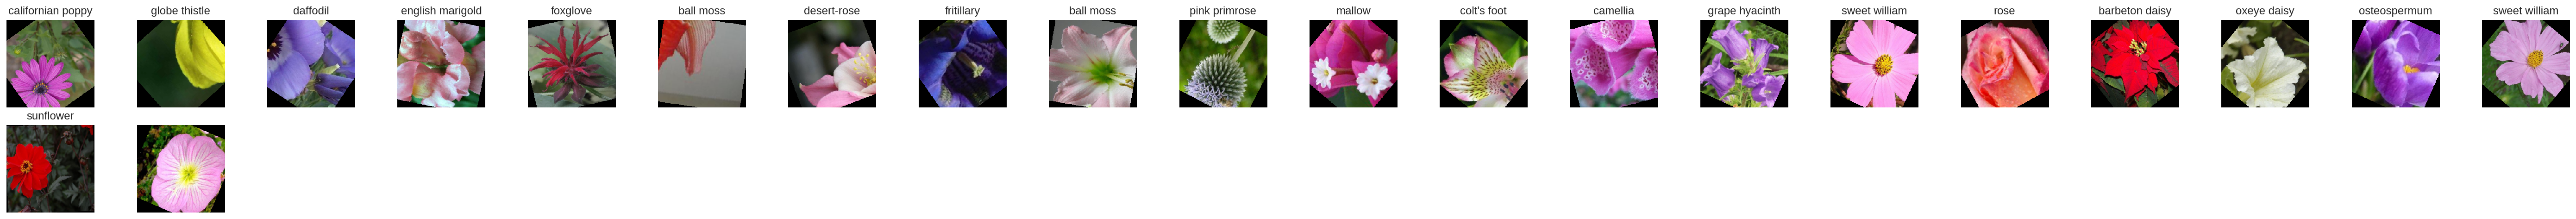

In [10]:
## Visualize some sample data

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(50, 8))
for idx in np.arange(31):
    ax = fig.add_subplot(4, 20, idx+1, xticks=[], yticks=[])
    image = ((np.transpose(images[idx], (1, 2, 0)) * std) + mean).clip(min=0)
    plt.imshow(image)
    ax.set_title(cat_to_name[str(labels[idx].item())])


In [11]:
print(len(cat_to_name))
print(cat_to_name['31'])

102
carnation


In [12]:
classes = len(cat_to_name)
print(classes)

102


tensor([ 73, 100,  43,  10,   6,   7,  26,  82,  12,  97,  24,  32,  82,  93,
         51,  54,   2,  13,  49,  33,  32,  84,   9,  84,  17,  90,  74,   8,
         76,  43,  79,  90])


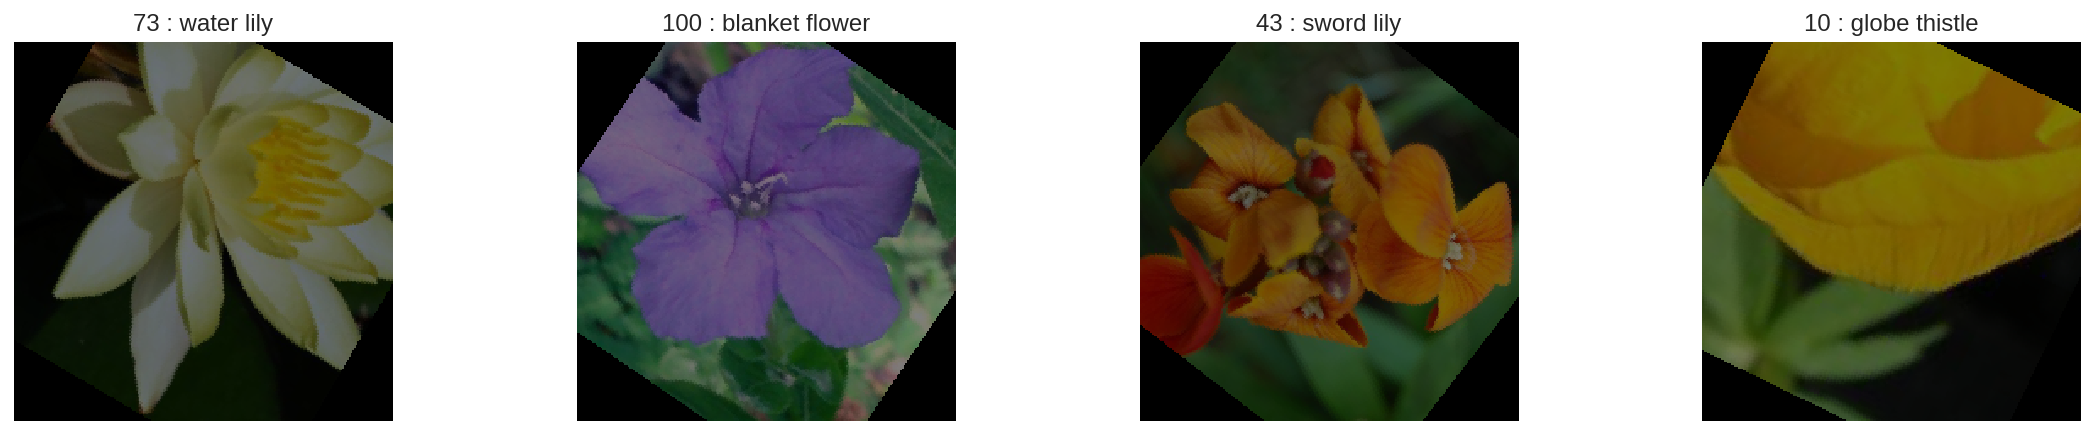

In [13]:
## Visualize some sample data  - #Amanda's code
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(labels)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(100, 16))
for idx in np.arange(4):
    ax = fig.add_subplot(4, 20, idx+1, xticks=[], yticks=[])
    image = ((np.transpose(images[idx], (1, 2, 0)) * std/2) + mean/2).clip(min=0)
    #image = ((np.transpose(images[idx], (1, 2, 0)))).clip(min=0)
    #image = image * norm_std + norm_mean
    plt.imshow(image)
    # labels = np.transpose(labels)
    ax.set_title(str(labels[idx].item()) + ' : ' + cat_to_name[str(labels[idx].item())])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [14]:

# TODO: Build and train your network
model = models.resnet101(pretrained=True)
#model 

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:02<00:00, 87809882.49it/s]


In [15]:
n_inputs = model.fc.in_features
n_outputs = model.fc.out_features

print(n_inputs) 
print(n_outputs)

2048
1000


In [0]:
# Freeze training for all "features" layers
for param in model.parameters():
    param.requires_grad = False

In [0]:
# Final Classifier Layer
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 1000),
                         nn.ReLU(),
                         nn.Dropout(0.40),
                         nn.Linear(1000, classes),
                         nn.LogSoftmax(dim=1))


# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

In [18]:
# check to see that your last layer produces the expected number of outputs
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4)
  (3): Linear(in_features=1000, out_features=102, bias=True)
  (4): LogSoftmax()
)


In [0]:
## Specify Loss Function and Optimizer

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.fc.parameters(), lr=0.0001, momentum=0.9)


In [0]:

def training_step(model, epoch=0):
    model.train()
    
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Training Model, Epoch {epoch}')):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        #### scheduler.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    
    return train_loss


In [0]:
def validation_step(model, epoch=0, criterion=None):
    model.eval()
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    correct_validation = 0.0
    total_analised = 0.0
    valid_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(tqdm(validation_loader, desc=f'Validating Model, Epoch {epoch}')):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate accuracy
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        correct_validation += correct.sum()
        total_analised += correct.size
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    valid_loss = valid_loss/len(validation_loader.dataset)
    accuaracy_validation = correct_validation / len(validation_loader.dataset)
    
    return valid_loss, accuaracy_validation

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
torch.save(model.state_dict(), 'model_epoch_100.pt')

#state_dict = torch.load('gdrive/My Drive/pytorch_models/model_epoch_100.pt')
#model.load_state_dict(state_dict)

In [28]:
valid_loss_min = 0 #np.Inf # track change in validation loss

# number of epochs to train the model
n_epochs = 100

train_loss_per_epoch = []
valid_loss_per_epoch = []
valid_accuracy_per_epoch = []

for epoch in range(1, n_epochs+1):
    train_loss = training_step(model, epoch)
    valid_loss, accuaracy_validation = validation_step(model, epoch, criterion)
    
    
    train_loss_per_epoch.append(train_loss)
    valid_loss_per_epoch.append(valid_loss)
    valid_accuracy_per_epoch.append(accuaracy_validation)
        
    # print training/validation statistics 
    print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tAccuracy: {accuaracy_validation*100:.6f}%')
    
    # save model if validation loss has decreased
    if valid_loss > valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'model_loss_decreased.pt')
        valid_loss_min = valid_loss
        !cp model_loss_decreased.pt 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt' 
    valid_loss_min = valid_loss    
        
torch.save(model.state_dict(), 'model_epoch_100.pt')
!cp model_epoch_100.pt 'gdrive/My Drive/pytorch_models/model_epoch_100.pt'


Training Model, Epoch 1: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 1: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]



Epoch: 1 	Training Loss: 4.585404 	Validation Loss: 4.547787 	Accuracy: 5.134474%
Validation loss decreased (0.000000 --> 4.547787).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 2: 100%|██████████| 205/205 [03:18<00:00,  1.10it/s]

Validating Model, Epoch 2: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 3:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 2 	Training Loss: 4.514830 	Validation Loss: 4.487496 	Accuracy: 5.501222%



Training Model, Epoch 3: 100%|██████████| 205/205 [03:18<00:00,  1.09it/s]

Validating Model, Epoch 3: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 4:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 3 	Training Loss: 4.470025 	Validation Loss: 4.442384 	Accuracy: 5.378973%



Training Model, Epoch 4: 100%|██████████| 205/205 [03:18<00:00,  1.10it/s]

Validating Model, Epoch 4: 100%|██████████| 26/26 [00:24<00:00,  1.21it/s]

Training Model, Epoch 5:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 4 	Training Loss: 4.436314 	Validation Loss: 4.410337 	Accuracy: 5.378973%



Training Model, Epoch 5: 100%|██████████| 205/205 [03:17<00:00,  1.11it/s]

Validating Model, Epoch 5: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 6:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 5 	Training Loss: 4.400232 	Validation Loss: 4.373405 	Accuracy: 6.112469%



Training Model, Epoch 6: 100%|██████████| 205/205 [03:18<00:00,  1.09it/s]

Validating Model, Epoch 6: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 7:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 6 	Training Loss: 4.367988 	Validation Loss: 4.333991 	Accuracy: 6.845966%



Training Model, Epoch 7: 100%|██████████| 205/205 [03:19<00:00,  1.10it/s]

Validating Model, Epoch 7: 100%|██████████| 26/26 [00:24<00:00,  1.21it/s]

Training Model, Epoch 8:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 7 	Training Loss: 4.337197 	Validation Loss: 4.306817 	Accuracy: 9.046455%



Training Model, Epoch 8: 100%|██████████| 205/205 [03:19<00:00,  1.10it/s]

Validating Model, Epoch 8: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 9:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 8 	Training Loss: 4.301546 	Validation Loss: 4.266377 	Accuracy: 9.902200%



Training Model, Epoch 9: 100%|██████████| 205/205 [03:19<00:00,  1.09it/s]

Validating Model, Epoch 9: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 10:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 9 	Training Loss: 4.269129 	Validation Loss: 4.231827 	Accuracy: 10.268949%



Training Model, Epoch 10: 100%|██████████| 205/205 [03:19<00:00,  1.10it/s]

Validating Model, Epoch 10: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 11:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 10 	Training Loss: 4.232782 	Validation Loss: 4.198432 	Accuracy: 11.246944%



Training Model, Epoch 11: 100%|██████████| 205/205 [03:18<00:00,  1.10it/s]

Validating Model, Epoch 11: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 12:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 11 	Training Loss: 4.193622 	Validation Loss: 4.163249 	Accuracy: 13.569682%



Training Model, Epoch 12: 100%|██████████| 205/205 [03:18<00:00,  1.09it/s]

Validating Model, Epoch 12: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 13:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 12 	Training Loss: 4.169734 	Validation Loss: 4.120540 	Accuracy: 15.158924%



Training Model, Epoch 13: 100%|██████████| 205/205 [03:18<00:00,  1.09it/s]

Validating Model, Epoch 13: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 14:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 13 	Training Loss: 4.125490 	Validation Loss: 4.080107 	Accuracy: 16.259169%



Training Model, Epoch 14: 100%|██████████| 205/205 [03:18<00:00,  1.10it/s]

Validating Model, Epoch 14: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 15:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 14 	Training Loss: 4.085440 	Validation Loss: 4.033126 	Accuracy: 16.870416%



Training Model, Epoch 15: 100%|██████████| 205/205 [03:18<00:00,  1.09it/s]

Validating Model, Epoch 15: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 16:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 15 	Training Loss: 4.045143 	Validation Loss: 3.997881 	Accuracy: 17.237164%



Training Model, Epoch 16: 100%|██████████| 205/205 [03:18<00:00,  1.09it/s]

Validating Model, Epoch 16: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 17:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 16 	Training Loss: 4.003589 	Validation Loss: 3.954684 	Accuracy: 18.704156%



Training Model, Epoch 17: 100%|██████████| 205/205 [03:17<00:00,  1.11it/s]

Validating Model, Epoch 17: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 18:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 17 	Training Loss: 3.962441 	Validation Loss: 3.911748 	Accuracy: 19.682152%



Training Model, Epoch 18: 100%|██████████| 205/205 [03:17<00:00,  1.11it/s]

Validating Model, Epoch 18: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 19:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 18 	Training Loss: 3.913182 	Validation Loss: 3.863822 	Accuracy: 20.415648%



Training Model, Epoch 19: 100%|██████████| 205/205 [03:17<00:00,  1.09it/s]

Validating Model, Epoch 19: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 20:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 19 	Training Loss: 3.866244 	Validation Loss: 3.796628 	Accuracy: 22.616137%



Training Model, Epoch 20: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 20: 100%|██████████| 26/26 [00:23<00:00,  1.20it/s]

Training Model, Epoch 21:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 20 	Training Loss: 3.823164 	Validation Loss: 3.770856 	Accuracy: 23.105134%



Training Model, Epoch 21: 100%|██████████| 205/205 [03:18<00:00,  1.09it/s]

Validating Model, Epoch 21: 100%|██████████| 26/26 [00:24<00:00,  1.18it/s]

Training Model, Epoch 22:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 21 	Training Loss: 3.781625 	Validation Loss: 3.700455 	Accuracy: 25.550122%



Training Model, Epoch 22: 100%|██████████| 205/205 [03:17<00:00,  1.11it/s]

Validating Model, Epoch 22: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 23:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 22 	Training Loss: 3.728295 	Validation Loss: 3.651010 	Accuracy: 25.794621%



Training Model, Epoch 23: 100%|██████████| 205/205 [03:16<00:00,  1.11it/s]

Validating Model, Epoch 23: 100%|██████████| 26/26 [00:23<00:00,  1.22it/s]

Training Model, Epoch 24:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 23 	Training Loss: 3.689188 	Validation Loss: 3.605371 	Accuracy: 26.772616%



Training Model, Epoch 24: 100%|██████████| 205/205 [03:15<00:00,  1.11it/s]

Validating Model, Epoch 24: 100%|██████████| 26/26 [00:23<00:00,  1.20it/s]

Training Model, Epoch 25:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 24 	Training Loss: 3.641707 	Validation Loss: 3.567414 	Accuracy: 27.383863%



Training Model, Epoch 25: 100%|██████████| 205/205 [03:16<00:00,  1.11it/s]

Validating Model, Epoch 25: 100%|██████████| 26/26 [00:24<00:00,  1.21it/s]

Training Model, Epoch 26:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 25 	Training Loss: 3.589786 	Validation Loss: 3.521414 	Accuracy: 28.606357%



Training Model, Epoch 26: 100%|██████████| 205/205 [03:18<00:00,  1.09it/s]

Validating Model, Epoch 26: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 27:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 26 	Training Loss: 3.537974 	Validation Loss: 3.461690 	Accuracy: 30.317848%



Training Model, Epoch 27: 100%|██████████| 205/205 [03:19<00:00,  1.09it/s]

Validating Model, Epoch 27: 100%|██████████| 26/26 [00:23<00:00,  1.20it/s]

Training Model, Epoch 28:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 27 	Training Loss: 3.489418 	Validation Loss: 3.402857 	Accuracy: 31.540342%



Training Model, Epoch 28: 100%|██████████| 205/205 [03:17<00:00,  1.11it/s]

Validating Model, Epoch 28: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 29:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 28 	Training Loss: 3.447162 	Validation Loss: 3.362229 	Accuracy: 30.562347%



Training Model, Epoch 29: 100%|██████████| 205/205 [03:19<00:00,  1.11it/s]

Validating Model, Epoch 29: 100%|██████████| 26/26 [00:23<00:00,  1.22it/s]

Training Model, Epoch 30:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 29 	Training Loss: 3.397424 	Validation Loss: 3.307671 	Accuracy: 32.029340%



Training Model, Epoch 30: 100%|██████████| 205/205 [03:16<00:00,  1.11it/s]

Validating Model, Epoch 30: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 31:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 30 	Training Loss: 3.338688 	Validation Loss: 3.241086 	Accuracy: 33.007335%



Training Model, Epoch 31: 100%|██████████| 205/205 [03:17<00:00,  1.11it/s]

Validating Model, Epoch 31: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 32:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 31 	Training Loss: 3.296151 	Validation Loss: 3.227243 	Accuracy: 34.841076%



Training Model, Epoch 32: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 32: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 33:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 32 	Training Loss: 3.247260 	Validation Loss: 3.179040 	Accuracy: 35.941320%



Training Model, Epoch 33: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 33: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 34:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 33 	Training Loss: 3.212643 	Validation Loss: 3.123307 	Accuracy: 33.740831%



Training Model, Epoch 34: 100%|██████████| 205/205 [03:18<00:00,  1.10it/s]

Validating Model, Epoch 34: 100%|██████████| 26/26 [00:24<00:00,  1.21it/s]

Training Model, Epoch 35:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 34 	Training Loss: 3.169032 	Validation Loss: 3.097164 	Accuracy: 35.696822%



Training Model, Epoch 35: 100%|██████████| 205/205 [03:18<00:00,  1.10it/s]

Validating Model, Epoch 35: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 36:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 35 	Training Loss: 3.119119 	Validation Loss: 3.012369 	Accuracy: 37.775061%



Training Model, Epoch 36: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 36: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 37:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 36 	Training Loss: 3.073135 	Validation Loss: 2.966173 	Accuracy: 38.630807%



Training Model, Epoch 37: 100%|██████████| 205/205 [03:16<00:00,  1.12it/s]

Validating Model, Epoch 37: 100%|██████████| 26/26 [00:23<00:00,  1.22it/s]

Training Model, Epoch 38:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 37 	Training Loss: 3.029172 	Validation Loss: 2.899440 	Accuracy: 42.053790%



Training Model, Epoch 38: 100%|██████████| 205/205 [03:15<00:00,  1.12it/s]

Validating Model, Epoch 38: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 39:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 38 	Training Loss: 2.981743 	Validation Loss: 2.885769 	Accuracy: 39.486553%



Training Model, Epoch 39: 100%|██████████| 205/205 [03:16<00:00,  1.11it/s]

Validating Model, Epoch 39: 100%|██████████| 26/26 [00:23<00:00,  1.22it/s]

Training Model, Epoch 40:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 39 	Training Loss: 2.928319 	Validation Loss: 2.836761 	Accuracy: 41.809291%



Training Model, Epoch 40: 100%|██████████| 205/205 [03:15<00:00,  1.10it/s]

Validating Model, Epoch 40: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 41:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 40 	Training Loss: 2.893452 	Validation Loss: 2.766436 	Accuracy: 42.298289%



Training Model, Epoch 41: 100%|██████████| 205/205 [03:16<00:00,  1.12it/s]

Validating Model, Epoch 41: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 42:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 41 	Training Loss: 2.852135 	Validation Loss: 2.752604 	Accuracy: 44.376528%



Training Model, Epoch 42: 100%|██████████| 205/205 [03:15<00:00,  1.11it/s]

Validating Model, Epoch 42: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 43:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 42 	Training Loss: 2.814890 	Validation Loss: 2.708635 	Accuracy: 43.398533%



Training Model, Epoch 43: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 43: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 44:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 43 	Training Loss: 2.789077 	Validation Loss: 2.644557 	Accuracy: 44.865526%



Training Model, Epoch 44: 100%|██████████| 205/205 [03:17<00:00,  1.09it/s]

Validating Model, Epoch 44: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 45:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 44 	Training Loss: 2.721698 	Validation Loss: 2.590268 	Accuracy: 47.432763%



Training Model, Epoch 45: 100%|██████████| 205/205 [03:16<00:00,  1.10it/s]

Validating Model, Epoch 45: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]



Epoch: 45 	Training Loss: 2.702275 	Validation Loss: 2.596645 	Accuracy: 47.677262%
Validation loss decreased (2.590268 --> 2.596645).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 46: 100%|██████████| 205/205 [03:14<00:00,  1.12it/s]

Validating Model, Epoch 46: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 47:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 46 	Training Loss: 2.649873 	Validation Loss: 2.534006 	Accuracy: 48.166259%



Training Model, Epoch 47: 100%|██████████| 205/205 [03:13<00:00,  1.11it/s]

Validating Model, Epoch 47: 100%|██████████| 26/26 [00:23<00:00,  1.22it/s]

Training Model, Epoch 48:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 47 	Training Loss: 2.628707 	Validation Loss: 2.492074 	Accuracy: 47.677262%



Training Model, Epoch 48: 100%|██████████| 205/205 [03:14<00:00,  1.12it/s]

Validating Model, Epoch 48: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 49:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 48 	Training Loss: 2.584877 	Validation Loss: 2.460565 	Accuracy: 49.388753%



Training Model, Epoch 49: 100%|██████████| 205/205 [03:13<00:00,  1.13it/s]

Validating Model, Epoch 49: 100%|██████████| 26/26 [00:23<00:00,  1.25it/s]

Training Model, Epoch 50:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 49 	Training Loss: 2.557461 	Validation Loss: 2.421989 	Accuracy: 48.288509%



Training Model, Epoch 50: 100%|██████████| 205/205 [03:12<00:00,  1.14it/s]

Validating Model, Epoch 50: 100%|██████████| 26/26 [00:23<00:00,  1.25it/s]

Training Model, Epoch 51:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 50 	Training Loss: 2.526488 	Validation Loss: 2.399346 	Accuracy: 48.655257%



Training Model, Epoch 51: 100%|██████████| 205/205 [03:12<00:00,  1.13it/s]

Validating Model, Epoch 51: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 52:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 51 	Training Loss: 2.475382 	Validation Loss: 2.379826 	Accuracy: 50.733496%



Training Model, Epoch 52: 100%|██████████| 205/205 [03:12<00:00,  1.14it/s]

Validating Model, Epoch 52: 100%|██████████| 26/26 [00:23<00:00,  1.24it/s]

Training Model, Epoch 53:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 52 	Training Loss: 2.449036 	Validation Loss: 2.330307 	Accuracy: 52.567237%



Training Model, Epoch 53: 100%|██████████| 205/205 [03:14<00:00,  1.12it/s]

Validating Model, Epoch 53: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 54:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 53 	Training Loss: 2.410022 	Validation Loss: 2.325976 	Accuracy: 49.877751%



Training Model, Epoch 54: 100%|██████████| 205/205 [03:14<00:00,  1.13it/s]

Validating Model, Epoch 54: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 55:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 54 	Training Loss: 2.376862 	Validation Loss: 2.265945 	Accuracy: 52.078240%



Training Model, Epoch 55: 100%|██████████| 205/205 [03:13<00:00,  1.12it/s]

Validating Model, Epoch 55: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 56:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 55 	Training Loss: 2.357444 	Validation Loss: 2.231441 	Accuracy: 54.278729%



Training Model, Epoch 56: 100%|██████████| 205/205 [03:13<00:00,  1.11it/s]

Validating Model, Epoch 56: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 57:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 56 	Training Loss: 2.323431 	Validation Loss: 2.163829 	Accuracy: 56.479218%



Training Model, Epoch 57: 100%|██████████| 205/205 [03:14<00:00,  1.12it/s]

Validating Model, Epoch 57: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 58:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 57 	Training Loss: 2.288951 	Validation Loss: 2.142914 	Accuracy: 55.990220%



Training Model, Epoch 58: 100%|██████████| 205/205 [03:14<00:00,  1.13it/s]

Validating Model, Epoch 58: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 59:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 58 	Training Loss: 2.272288 	Validation Loss: 2.141951 	Accuracy: 55.134474%



Training Model, Epoch 59: 100%|██████████| 205/205 [03:15<00:00,  1.11it/s]

Validating Model, Epoch 59: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 60:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 59 	Training Loss: 2.239502 	Validation Loss: 2.097937 	Accuracy: 56.479218%



Training Model, Epoch 60: 100%|██████████| 205/205 [03:15<00:00,  1.13it/s]

Validating Model, Epoch 60: 100%|██████████| 26/26 [00:23<00:00,  1.23it/s]

Training Model, Epoch 61:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 60 	Training Loss: 2.214241 	Validation Loss: 2.089965 	Accuracy: 56.356968%



Training Model, Epoch 61: 100%|██████████| 205/205 [03:16<00:00,  1.10it/s]

Validating Model, Epoch 61: 100%|██████████| 26/26 [00:23<00:00,  1.20it/s]

Training Model, Epoch 62:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 61 	Training Loss: 2.175638 	Validation Loss: 2.048790 	Accuracy: 58.312958%



Training Model, Epoch 62: 100%|██████████| 205/205 [03:26<00:00,  1.02it/s]

Validating Model, Epoch 62: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]



Epoch: 62 	Training Loss: 2.176748 	Validation Loss: 2.052572 	Accuracy: 57.701711%
Validation loss decreased (2.048790 --> 2.052572).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 63: 100%|██████████| 205/205 [03:21<00:00,  1.06it/s]

Validating Model, Epoch 63: 100%|██████████| 26/26 [00:24<00:00,  1.17it/s]

Training Model, Epoch 64:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 63 	Training Loss: 2.157713 	Validation Loss: 1.991966 	Accuracy: 58.801956%



Training Model, Epoch 64: 100%|██████████| 205/205 [03:21<00:00,  1.07it/s]

Validating Model, Epoch 64: 100%|██████████| 26/26 [00:24<00:00,  1.17it/s]

Training Model, Epoch 65:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 64 	Training Loss: 2.099024 	Validation Loss: 1.958945 	Accuracy: 60.024450%



Training Model, Epoch 65: 100%|██████████| 205/205 [03:21<00:00,  1.09it/s]

Validating Model, Epoch 65: 100%|██████████| 26/26 [00:24<00:00,  1.17it/s]



Epoch: 65 	Training Loss: 2.084051 	Validation Loss: 1.962910 	Accuracy: 58.801956%
Validation loss decreased (1.958945 --> 1.962910).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 66: 100%|██████████| 205/205 [03:21<00:00,  1.08it/s]

Validating Model, Epoch 66: 100%|██████████| 26/26 [00:24<00:00,  1.18it/s]

Training Model, Epoch 67:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 66 	Training Loss: 2.070886 	Validation Loss: 1.948484 	Accuracy: 58.435208%



Training Model, Epoch 67: 100%|██████████| 205/205 [03:20<00:00,  1.09it/s]

Validating Model, Epoch 67: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 68:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 67 	Training Loss: 2.026973 	Validation Loss: 1.906392 	Accuracy: 62.713936%



Training Model, Epoch 68: 100%|██████████| 205/205 [03:18<00:00,  1.14it/s]

Validating Model, Epoch 68: 100%|██████████| 26/26 [00:23<00:00,  1.22it/s]

Training Model, Epoch 69:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 68 	Training Loss: 2.020177 	Validation Loss: 1.855982 	Accuracy: 63.080685%



Training Model, Epoch 69: 100%|██████████| 205/205 [03:15<00:00,  1.13it/s]

Validating Model, Epoch 69: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]



Epoch: 69 	Training Loss: 1.986054 	Validation Loss: 1.868193 	Accuracy: 60.513447%
Validation loss decreased (1.855982 --> 1.868193).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 70: 100%|██████████| 205/205 [03:16<00:00,  1.10it/s]

Validating Model, Epoch 70: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]



Epoch: 70 	Training Loss: 1.964881 	Validation Loss: 1.872539 	Accuracy: 61.002445%
Validation loss decreased (1.868193 --> 1.872539).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 71: 100%|██████████| 205/205 [03:18<00:00,  1.08it/s]

Validating Model, Epoch 71: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 72:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 71 	Training Loss: 1.959269 	Validation Loss: 1.797847 	Accuracy: 63.080685%



Training Model, Epoch 72: 100%|██████████| 205/205 [03:19<00:00,  1.10it/s]

Validating Model, Epoch 72: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]



Epoch: 72 	Training Loss: 1.931970 	Validation Loss: 1.818199 	Accuracy: 62.591687%
Validation loss decreased (1.797847 --> 1.818199).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 73: 100%|██████████| 205/205 [03:19<00:00,  1.10it/s]

Validating Model, Epoch 73: 100%|██████████| 26/26 [00:24<00:00,  1.18it/s]

Training Model, Epoch 74:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 73 	Training Loss: 1.915709 	Validation Loss: 1.766131 	Accuracy: 62.469438%



Training Model, Epoch 74: 100%|██████████| 205/205 [03:20<00:00,  1.09it/s]

Validating Model, Epoch 74: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]



Epoch: 74 	Training Loss: 1.898007 	Validation Loss: 1.773771 	Accuracy: 63.691932%
Validation loss decreased (1.766131 --> 1.773771).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 75: 100%|██████████| 205/205 [03:20<00:00,  1.08it/s]

Validating Model, Epoch 75: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 76:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 75 	Training Loss: 1.887867 	Validation Loss: 1.722776 	Accuracy: 64.303178%



Training Model, Epoch 76: 100%|██████████| 205/205 [03:20<00:00,  1.08it/s]

Validating Model, Epoch 76: 100%|██████████| 26/26 [00:24<00:00,  1.18it/s]



Epoch: 76 	Training Loss: 1.860703 	Validation Loss: 1.767943 	Accuracy: 65.647922%
Validation loss decreased (1.722776 --> 1.767943).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 77: 100%|██████████| 205/205 [03:20<00:00,  1.11it/s]

Validating Model, Epoch 77: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 78:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 77 	Training Loss: 1.830973 	Validation Loss: 1.719737 	Accuracy: 63.325183%



Training Model, Epoch 78: 100%|██████████| 205/205 [03:20<00:00,  1.09it/s]

Validating Model, Epoch 78: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 79:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 78 	Training Loss: 1.834262 	Validation Loss: 1.711725 	Accuracy: 64.180929%



Training Model, Epoch 79: 100%|██████████| 205/205 [03:20<00:00,  1.09it/s]

Validating Model, Epoch 79: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 80:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 79 	Training Loss: 1.798353 	Validation Loss: 1.636279 	Accuracy: 66.625917%



Training Model, Epoch 80: 100%|██████████| 205/205 [03:19<00:00,  1.08it/s]

Validating Model, Epoch 80: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 81:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 80 	Training Loss: 1.790494 	Validation Loss: 1.619736 	Accuracy: 65.892421%



Training Model, Epoch 81: 100%|██████████| 205/205 [03:19<00:00,  1.09it/s]

Validating Model, Epoch 81: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 82:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 81 	Training Loss: 1.763311 	Validation Loss: 1.608077 	Accuracy: 65.036675%



Training Model, Epoch 82: 100%|██████████| 205/205 [03:19<00:00,  1.10it/s]

Validating Model, Epoch 82: 100%|██████████| 26/26 [00:24<00:00,  1.18it/s]



Epoch: 82 	Training Loss: 1.744399 	Validation Loss: 1.650318 	Accuracy: 64.303178%
Validation loss decreased (1.608077 --> 1.650318).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 83: 100%|██████████| 205/205 [03:19<00:00,  1.10it/s]

Validating Model, Epoch 83: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 84:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 83 	Training Loss: 1.751736 	Validation Loss: 1.576078 	Accuracy: 68.337408%



Training Model, Epoch 84: 100%|██████████| 205/205 [03:19<00:00,  1.08it/s]

Validating Model, Epoch 84: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]



Epoch: 84 	Training Loss: 1.740632 	Validation Loss: 1.600620 	Accuracy: 65.036675%
Validation loss decreased (1.576078 --> 1.600620).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 85: 100%|██████████| 205/205 [03:19<00:00,  1.10it/s]

Validating Model, Epoch 85: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 86:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 85 	Training Loss: 1.696611 	Validation Loss: 1.532635 	Accuracy: 69.804401%



Training Model, Epoch 86: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 86: 100%|██████████| 26/26 [00:24<00:00,  1.21it/s]

Training Model, Epoch 87:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 86 	Training Loss: 1.705807 	Validation Loss: 1.527086 	Accuracy: 67.848411%



Training Model, Epoch 87: 100%|██████████| 205/205 [03:17<00:00,  1.11it/s]

Validating Model, Epoch 87: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]



Epoch: 87 	Training Loss: 1.688708 	Validation Loss: 1.562936 	Accuracy: 67.237164%
Validation loss decreased (1.527086 --> 1.562936).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 88: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 88: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 89:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 88 	Training Loss: 1.673522 	Validation Loss: 1.524011 	Accuracy: 67.114914%



Training Model, Epoch 89: 100%|██████████| 205/205 [03:16<00:00,  1.11it/s]

Validating Model, Epoch 89: 100%|██████████| 26/26 [00:23<00:00,  1.20it/s]

Training Model, Epoch 90:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 89 	Training Loss: 1.654121 	Validation Loss: 1.491886 	Accuracy: 69.193154%



Training Model, Epoch 90: 100%|██████████| 205/205 [03:16<00:00,  1.11it/s]

Validating Model, Epoch 90: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]

Training Model, Epoch 91:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 90 	Training Loss: 1.633465 	Validation Loss: 1.439973 	Accuracy: 69.559902%



Training Model, Epoch 91: 100%|██████████| 205/205 [03:17<00:00,  1.10it/s]

Validating Model, Epoch 91: 100%|██████████| 26/26 [00:23<00:00,  1.21it/s]



Epoch: 91 	Training Loss: 1.645271 	Validation Loss: 1.514430 	Accuracy: 68.092910%
Validation loss decreased (1.439973 --> 1.514430).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 92: 100%|██████████| 205/205 [03:19<00:00,  1.08it/s]

Validating Model, Epoch 92: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]

Training Model, Epoch 93:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 92 	Training Loss: 1.601163 	Validation Loss: 1.455061 	Accuracy: 69.437653%



Training Model, Epoch 93: 100%|██████████| 205/205 [03:20<00:00,  1.08it/s]

Validating Model, Epoch 93: 100%|██████████| 26/26 [00:24<00:00,  1.18it/s]

Training Model, Epoch 94:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 93 	Training Loss: 1.596118 	Validation Loss: 1.445644 	Accuracy: 67.970660%



Training Model, Epoch 94: 100%|██████████| 205/205 [03:19<00:00,  1.09it/s]

Validating Model, Epoch 94: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]

Training Model, Epoch 95:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 94 	Training Loss: 1.606688 	Validation Loss: 1.410300 	Accuracy: 71.638142%



Training Model, Epoch 95: 100%|██████████| 205/205 [03:19<00:00,  1.09it/s]

Validating Model, Epoch 95: 100%|██████████| 26/26 [00:24<00:00,  1.20it/s]



Epoch: 95 	Training Loss: 1.564187 	Validation Loss: 1.433351 	Accuracy: 68.581907%
Validation loss decreased (1.410300 --> 1.433351).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 96: 100%|██████████| 205/205 [03:20<00:00,  1.09it/s]

Validating Model, Epoch 96: 100%|██████████| 26/26 [00:24<00:00,  1.21it/s]

Training Model, Epoch 97:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 96 	Training Loss: 1.562461 	Validation Loss: 1.374407 	Accuracy: 71.515892%



Training Model, Epoch 97: 100%|██████████| 205/205 [03:20<00:00,  1.09it/s]

Validating Model, Epoch 97: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]



Epoch: 97 	Training Loss: 1.571632 	Validation Loss: 1.442142 	Accuracy: 69.926650%
Validation loss decreased (1.374407 --> 1.442142).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 98: 100%|██████████| 205/205 [03:19<00:00,  1.09it/s]

Validating Model, Epoch 98: 100%|██████████| 26/26 [00:24<00:00,  1.18it/s]

Training Model, Epoch 99:   0%|          | 0/205 [00:00<?, ?it/s]


Epoch: 98 	Training Loss: 1.561144 	Validation Loss: 1.374267 	Accuracy: 70.171149%



Training Model, Epoch 99: 100%|██████████| 205/205 [03:20<00:00,  1.08it/s]

Validating Model, Epoch 99: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]



Epoch: 99 	Training Loss: 1.516097 	Validation Loss: 1.431527 	Accuracy: 70.415648%
Validation loss decreased (1.374267 --> 1.431527).  Saving model ...
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_loss_decreased.pt': No such file or directory



Training Model, Epoch 100: 100%|██████████| 205/205 [03:19<00:00,  1.09it/s]

Validating Model, Epoch 100: 100%|██████████| 26/26 [00:24<00:00,  1.19it/s]



Epoch: 100 	Training Loss: 1.538134 	Validation Loss: 1.405519 	Accuracy: 69.804401%
cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_epoch_100.pt': No such file or directory


In [30]:

torch.save(model.state_dict(), 'model_epoch_101.pt')
!cp model_epoch_101.pt 'gdrive/My Drive/pytorch_models/model_epoch_101.pt'

cp: cannot create regular file 'gdrive/My Drive/pytorch_models/model_epoch_101.pt': No such file or directory


In [0]:
torch.save(model.state_dict(), 'model_temp2.pt')

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:

if IN_COLAB:
    model = torch.load('gdrive/My Drive/pytorch_challenge_models/model.pth')
else:
    model = torch.load('model.pth')
    
print('Model Loaded!')

_, accuaracy_validation = validation_step(model)
print(f'Model Loaded! Validation Accuracy {accuaracy_validation*100:.2f}%')

NameError: ignored

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/PaulaOlivio/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes